# 导包

In [1]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

2025-05-08 14:15:00.691343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:15:01.107369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746684901.449872   33621 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746684901.539953   33621 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746684901.973892   33621 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

23

In [2]:
depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')

# Layer2

In [3]:
# data_st_processed = np.load(r'./data_st_processed.npy')
# data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
data_underwater = np.load(r'./layer1/predict_data.npy')
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,1:2] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 6)
(12, 16000, 9, 9, 6)
(12, 16000, 9, 9, 6)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 6)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1745203951.136347  328268 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745203956.025330  328442 service.cc:152] XLA service 0x7fdd64019f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745203956.025429  328442 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-21 10:52:36.056588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745203956.185194  328442 cuda_dnn.cc:529] Loaded cuDNN version 90800


  18/5544 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step

I0000 00:00:1745203957.808180  328442 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step
layer2 R² score: 0.9936796426773071
layer2 Test mae: 0.184
Results written to results.txt
[[27.83139992 27.88701439 28.00181389 ... 27.26662254 27.29999352
  27.25516891]
 [27.86928749 27.93628693 28.00976753 ... 27.09736824 27.20450211
  27.26537323]
 [27.96696472 27.87182999 27.92880821 ... 27.11912346 27.14565086
  27.20910835]
 ...
 [12.86922073 12.73709583 12.36215973 ... 14.17791176 14.23809624
  14.20241833]
 [13.00329685 12.6845541  12.63657475 ... 13.52140999 13.58237267
  13.49485016]
 [        nan         nan 11.80435753 ... 12.24917793 12.14230347
  11.86228371]]


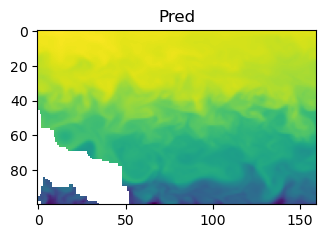

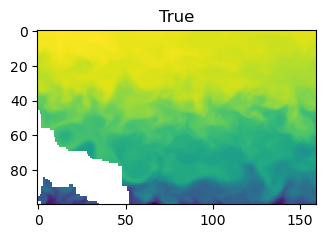

[[27.70992088 27.73189545 27.75020599 ... 27.10785294 27.12103653
  27.14593887]
 [27.69234276 27.71578217 27.7370224  ... 27.05877876 27.07928658
  27.1100502 ]
 [27.70113182 27.72457123 27.74434662 ... 27.00970459 27.02947998
  27.06830025]
 ...
 [12.85302258 12.92773247 12.60838604 ... 14.20438194 14.24832916
  14.23514557]
 [13.27344608 12.58787823 12.82665443 ... 13.51808167 13.60817337
  13.54884529]
 [        nan         nan 11.80416298 ... 12.30661869 12.24289703
  12.0883503 ]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer2/CNN_model_layer2_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:6]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer2_st = scaler_l.inverse_transform(result)
y_test_layer2_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer2_unscaled[:,0],predict_layer2_st[:,0])
print('layer2 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer2_unscaled[:,0]-predict_layer2_st[:,0])))
print('layer2 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer2_st
true_data[non_nan_mask] = y_test_layer2_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer2/results.txt", "w") as file:
    file.write(f"layer2 R² score: {r2}\n")
    file.write(f"layer2 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer2/predict_data.npy',predict_data)
np.save(r'./layer2/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer3

In [6]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,2:3] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [7]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 7)
(12, 16000, 9, 9, 7)
(12, 16000, 9, 9, 7)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 7)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step
layer3 R² score: 0.9641425013542175
layer3 Test mae: 0.563
Results written to results.txt
[[27.73000717 27.65034103 27.61097336 ... 26.76655769 26.83913994
  26.85896492]
 [27.58379745 27.55326653 27.6143074  ... 26.66693497 26.72813606
  26.77177429]
 [27.48039818 27.49058342 27.58520699 ... 26.5544281  26.50571632
  26.55176544]
 ...
 [12.80262184 12.71574783 12.3411932  ... 13.97901821 14.11532307
  14.0895834 ]
 [12.90951061 12.73814583 12.6983757  ... 13.42567253 13.51888561
  13.46144485]
 [        nan         nan 11.62276745 ... 12.16935444 12.0667963
  11.76505089]]


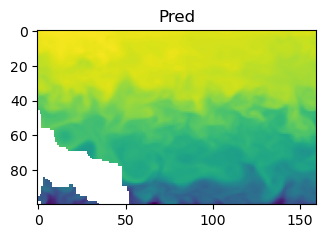

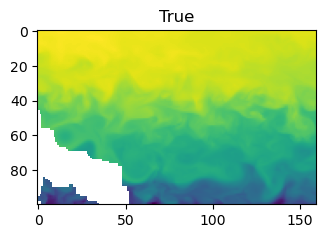

[[27.69014549 27.71871185 27.74288177 ... 27.0997963  27.11224747
  27.13714981]
 [27.67549706 27.70332909 27.7304306  ... 27.05072212 27.07049751
  27.09906387]
 [27.68941307 27.71504974 27.73336029 ... 27.00311279 27.02215576
  27.05731392]
 ...
 [12.84936047 12.92407036 12.60545635 ... 14.20145226 14.24832916
  14.23441315]
 [13.20166588 12.56810188 12.74169159 ... 13.50050354 13.60011578
  13.54152107]
 [        nan         nan 11.6664629  ... 12.29563236 12.22971249
  12.07223701]]


14380

In [8]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer3/CNN_model_layer3_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:7]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer3_st = scaler_l.inverse_transform(result)
y_test_layer3_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer3_unscaled[:,0],predict_layer3_st[:,0])
print('layer3 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer3_unscaled[:,0]-predict_layer3_st[:,0])))
print('layer3 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer3_st
true_data[non_nan_mask] = y_test_layer3_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer3/results.txt", "w") as file:
    file.write(f"layer3 R² score: {r2}\n")
    file.write(f"layer3 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer3/predict_data.npy',predict_data)
np.save(r'./layer3/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer4

In [9]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,3:4] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [10]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 8)
(12, 16000, 9, 9, 8)
(12, 16000, 9, 9, 8)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 8)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step
layer4 R² score: 0.9607573747634888
layer4 Test mae: 0.621
Results written to results.txt
[[27.53322983 27.74141312 27.7349968  ... 26.70525169 26.61660767
  26.33961868]
 [27.5897541  27.65828705 27.6884861  ... 26.53527069 26.51780701
  26.44688416]
 [27.23458481 27.47086143 27.57721519 ... 26.3329525  26.33203506
  26.28195953]
 ...
 [12.5999794  12.54228687 12.15219021 ... 14.02827168 14.04983997
  14.01075935]
 [12.42907143 12.28252125 12.19358253 ... 13.36167812 13.46851921
  13.46210861]
 [        nan         nan 10.58897877 ... 12.20408249 12.16242123
  11.96349525]]


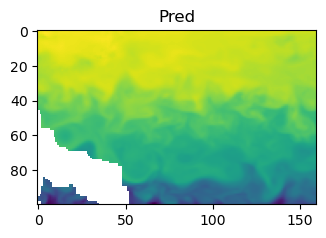

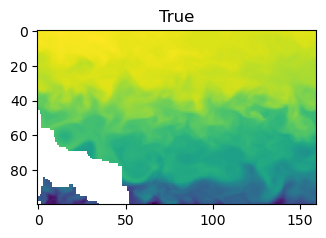

[[27.67110252 27.69893456 27.72896576 ... 27.09027481 27.10199356
  27.12176895]
 [27.64986038 27.68135643 27.71431732 ... 27.04706001 27.05145454
  27.07708931]
 [27.66524315 27.69014549 27.71285248 ... 26.99505615 27.00750732
  27.03167725]
 ...
 [12.82152653 12.89037704 12.54612732 ... 14.19412804 14.24759674
  14.23221588]
 [13.03979778 12.44065666 12.40183735 ... 13.47706604 13.58619976
  13.52467346]
 [        nan         nan 10.90765095 ... 12.27732182 12.20700741
  12.05099773]]


14375

In [11]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer4/CNN_model_layer4_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:8]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer4_st = scaler_l.inverse_transform(result)
y_test_layer4_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer4_unscaled[:,0],predict_layer4_st[:,0])
print('layer4 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer4_unscaled[:,0]-predict_layer4_st[:,0])))
print('layer4 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer4_st
true_data[non_nan_mask] = y_test_layer4_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer4/results.txt", "w") as file:
    file.write(f"layer4 R² score: {r2}\n")
    file.write(f"layer4 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer4/predict_data.npy',predict_data)
np.save(r'./layer4/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer5

In [12]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,4:5] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [13]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 9)
(12, 16000, 9, 9, 9)
(12, 16000, 9, 9, 9)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 9)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step
layer5 R² score: 0.9612259864807129
layer5 Test mae: 0.639
Results written to results.txt
[[27.1735096  27.27709007 27.38785553 ... 26.34453583 26.42461586
  26.132761  ]
 [27.1591301  27.20424271 27.27784729 ... 26.21286964 26.27456474
  26.15789604]
 [27.07838249 27.13069153 27.15696716 ... 26.07786751 26.0560112
  26.02739143]
 ...
 [12.06874657 12.13514996 11.83006477 ... 13.87164593 13.98223019
  13.78078938]
 [11.84296131 11.80795956 11.84524059 ... 13.25725269 13.3940115
  13.0966711 ]
 [        nan         nan  9.94730759 ... 11.90167332 11.81371403
  11.25081348]]


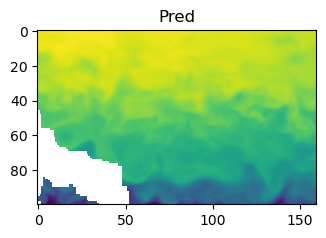

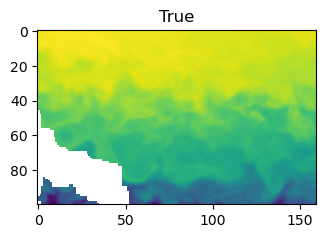

[[27.54585457 27.59932327 27.64473343 ... 26.99725342 26.98919678
  26.99725342]
 [27.59639359 27.63887405 27.68794823 ... 27.04706001 27.03387451
  27.05145454]
 [27.6337471  27.65279007 27.68501854 ... 27.00384521 27.00384521
  27.01116943]
 ...
 [12.78856754 12.79808998 12.41209126 ... 14.18826866 14.24686432
  14.23075104]
 [12.81859779 12.10959244 12.00851345 ... 13.46607876 13.57740974
  13.51808167]
 [        nan         nan 10.04116917 ... 12.26633549 12.19602013
  12.04220676]]


14370

In [14]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer5/CNN_model_layer5_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:9]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer5_st = scaler_l.inverse_transform(result)
y_test_layer5_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer5_unscaled[:,0],predict_layer5_st[:,0])
print('layer5 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer5_unscaled[:,0]-predict_layer5_st[:,0])))
print('layer5 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer5_st
true_data[non_nan_mask] = y_test_layer5_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer5/results.txt", "w") as file:
    file.write(f"layer5 R² score: {r2}\n")
    file.write(f"layer5 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer5/predict_data.npy',predict_data)
np.save(r'./layer5/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer6

In [15]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,5:6] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [16]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 10)
(12, 16000, 9, 9, 10)
(12, 16000, 9, 9, 10)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 10)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step
layer6 R² score: 0.9579702019691467
layer6 Test mae: 0.678
Results written to results.txt
[[26.93602371 26.99456215 27.04169846 ... 25.99419785 25.9050293
  25.46349335]
 [27.08864021 27.15039825 27.0892334  ... 25.90547371 25.88689423
  25.83783531]
 [27.01283646 26.97263718 26.91669655 ... 25.82933617 25.79782295
  25.70067787]
 ...
 [11.91506481 12.01926422 11.66164875 ... 13.86535072 13.87776375
  13.798522  ]
 [11.44097996 11.23584747 11.26651382 ... 13.23536873 13.24720669
  12.99396801]
 [        nan         nan  9.23760414 ... 12.06277657 11.84284496
  11.30688477]]


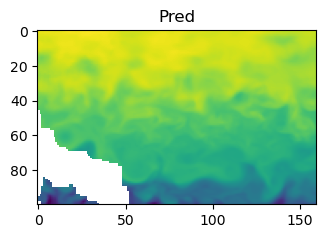

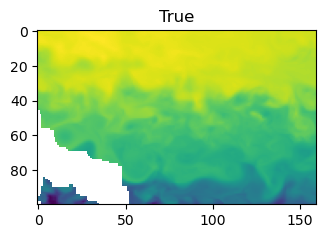

[[26.72551727 26.82366371 26.93206596 ... 26.12930679 26.16885948
  26.23917389]
 [26.97235107 27.01776123 27.06903267 ... 26.23990631 26.25382233
  26.30143166]
 [27.20380211 27.17597008 27.14447403 ... 26.34537888 26.27872467
  26.25016022]
 ...
 [12.66405201 12.54759407 12.1066618  ... 14.17215538 14.23660946
  14.22342587]
 [12.2099371  11.4313488  11.33832836 ... 13.44703484 13.56056404
  13.50343323]
 [        nan         nan  8.03061008 ... 12.22385311 12.17258263
  12.02462864]]


14380

In [17]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer6/CNN_model_layer6_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:10]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer6_st = scaler_l.inverse_transform(result)
y_test_layer6_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer6_unscaled[:,0],predict_layer6_st[:,0])
print('layer6 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer6_unscaled[:,0]-predict_layer6_st[:,0])))
print('layer6 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer6_st
true_data[non_nan_mask] = y_test_layer6_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer6/results.txt", "w") as file:
    file.write(f"layer6 R² score: {r2}\n")
    file.write(f"layer6 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer6/predict_data.npy',predict_data)
np.save(r'./layer6/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer7

In [18]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,6:7] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [19]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 11)


(12, 16000, 9, 9, 11)
(12, 16000, 9, 9, 11)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 11)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step
layer7 R² score: 0.9544979929924011
layer7 Test mae: 0.711
Results written to results.txt
[[26.26860237 26.49758339 26.56215858 ... 25.77487755 25.73765945
  25.48031616]
 [26.36741638 26.48043823 26.49499512 ... 25.78607178 25.75539398
  25.67292023]
 [26.28591728 26.298172   26.26469612 ... 25.67926025 25.76973152
  25.67335129]
 ...
 [11.51496315 11.47525883 11.18992233 ... 13.80402279 13.86279297
  13.62807369]
 [10.99812603 10.72228241 10.6839819  ... 13.08727074 13.16982269
  12.87435532]
 [        nan         nan  8.35047054 ... 11.88037205 11.79123211
  11.28948212]]


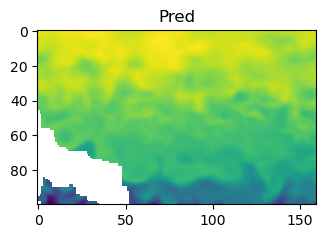

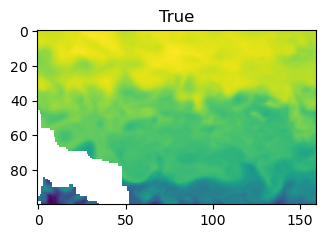

[[25.38148117 25.41883659 25.44666862 ... 24.94274712 24.97277832
  25.05188179]
 [25.6458931  25.64955521 25.63710403 ... 24.97058105 24.99035645
  25.06799507]
 [26.01358032 25.95718193 25.85830307 ... 24.97790527 24.93762016
  24.9588604 ]
 ...
 [12.43113518 12.05758858 11.56831551 ... 14.14432144 14.20657921
  14.19412804]
 [10.87542343  9.85439587  9.97158718 ... 13.36133862 13.4990387
  13.44556999]
 [        nan         nan  5.43775749 ... 12.10739422 12.09860516
  11.97775173]]


14375

In [20]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer7/CNN_model_layer7_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:11]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer7_st = scaler_l.inverse_transform(result)
y_test_layer7_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer7_unscaled[:,0],predict_layer7_st[:,0])
print('layer7 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer7_unscaled[:,0]-predict_layer7_st[:,0])))
print('layer7 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer7_st
true_data[non_nan_mask] = y_test_layer7_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer7/results.txt", "w") as file:
    file.write(f"layer7 R² score: {r2}\n")
    file.write(f"layer7 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer7/predict_data.npy',predict_data)
np.save(r'./layer7/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer8

In [21]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,7:8] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [22]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 12)
(12, 16000, 9, 9, 12)
(12, 16000, 9, 9, 12)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 12)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step
layer8 R² score: 0.9517520666122437
layer8 Test mae: 0.722
Results written to results.txt
[[24.9811554  25.24978638 25.18871689 ... 24.61327553 24.51994133
  24.33927536]
 [25.13450623 25.11590576 25.07790947 ... 24.65143585 24.66759491
  24.55764008]
 [25.0096302  25.16728973 25.04125404 ... 25.00426674 25.02557564
  24.89648438]
 ...
 [10.34212685 10.00929165  9.8362112  ... 13.73693275 13.83156776
  13.72115517]
 [ 9.32401562  8.86578751  8.73798561 ... 12.84101105 12.9858017
  12.7156744 ]
 [        nan         nan  6.19388819 ... 11.07765293 11.00025177
  10.54260921]]


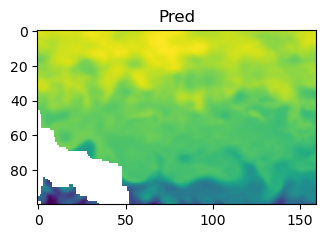

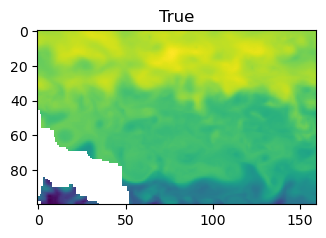

[[23.75545502 23.76644135 23.74446869 ... 23.31305885 23.39289474
  23.54377937]
 [24.0381794  24.03231812 23.98031616 ... 23.25153351 23.31379128
  23.43977165]
 [24.32090187 24.29966164 24.23593903 ... 23.19440269 23.2112484
  23.29548073]
 ...
 [ 9.86465073  9.13879776  9.02087402 ... 13.90627766 13.99563599
  14.00369263]
 [ 7.2381053   6.50785875  6.57084799 ... 13.03613377 13.21997738
  13.22217464]
 [        nan         nan  3.28949976 ... 11.94186211 11.96969509
  11.89498615]]


14380

In [23]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer8/CNN_model_layer8_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:12]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer8_st = scaler_l.inverse_transform(result)
y_test_layer8_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer8_unscaled[:,0],predict_layer8_st[:,0])
print('layer8 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer8_unscaled[:,0]-predict_layer8_st[:,0])))
print('layer8 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer8_st
true_data[non_nan_mask] = y_test_layer8_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer8/results.txt", "w") as file:
    file.write(f"layer8 R² score: {r2}\n")
    file.write(f"layer8 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer8/predict_data.npy',predict_data)
np.save(r'./layer8/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer9

In [6]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,8:9] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [7]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 13)
(12, 16000, 9, 9, 13)
(12, 16000, 9, 9, 13)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 13)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step
layer9 R² score: 0.9488824605941772
layer9 Test mae: 0.696
Results written to results.txt
[[23.54963303 23.61423302 23.52964783 ... 22.77980232 22.91111374
  22.96529579]
 [23.55397606 23.48788452 23.37541008 ... 23.01420212 23.08469772
  23.25570297]
 [23.42272758 23.29127693 23.19823647 ... 23.19643974 23.32844734
  23.32402611]
 ...
 [ 8.06478214  7.81803179  7.99056196 ... 13.2382946  13.33743382
  13.30886173]
 [ 7.31583166  6.77449179  6.99326944 ... 12.47804832 12.54237938
  12.42866898]
 [        nan         nan  4.43675566 ... 11.12650013 11.03541756
  10.73593712]]


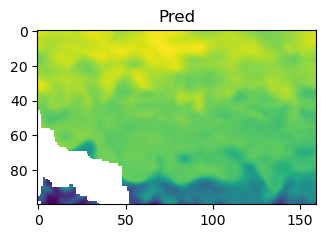

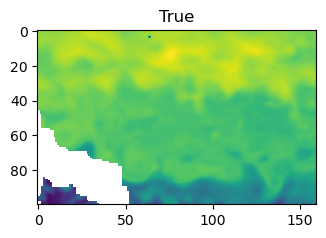

[[21.70461082 21.76686859 21.8005619  ... 21.11938858 21.32447243
  21.55519295]
 [21.96316338 22.00784302 22.01296997 ... 21.07251167 21.22779083
  21.5002594 ]
 [22.25540924 22.29349709 22.27957916 ... 21.04980659 21.14502335
  21.33545876]
 ...
 [ 6.46244669  6.0141902   6.30130816 ... 13.3591423  13.50856018
  13.52906895]
 [ 4.24533796  3.90475059  3.98019385 ... 12.51609898 12.69408226
  12.7204504 ]
 [        nan         nan  1.97695994 ... 11.42548943 11.4379406
  11.34858227]]


14375

In [8]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer9/CNN_model_layer9_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:13]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer9_st = scaler_l.inverse_transform(result)
y_test_layer9_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer9_unscaled[:,0],predict_layer9_st[:,0])
print('layer9 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer9_unscaled[:,0]-predict_layer9_st[:,0])))
print('layer9 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer9_st
true_data[non_nan_mask] = y_test_layer9_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer9/results.txt", "w") as file:
    file.write(f"layer9 R² score: {r2}\n")
    file.write(f"layer9 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer9/predict_data.npy',predict_data)
np.save(r'./layer9/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer10

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,9:10] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 14)
(12, 16000, 9, 9, 14)
(12, 16000, 9, 9, 14)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 14)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1745374720.313787   68976 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745374727.125253   69189 service.cc:152] XLA service 0x7f2d9800f4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745374727.125402   69189 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-23 10:18:47.161674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745374724.187812   69189 cuda_dnn.cc:529] Loaded cuDNN version 90800


  15/5544 ━━━━━━━━━━━━━━━━━━━━ 1:01 11ms/step     

I0000 00:00:1745374726.185014   69189 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step
layer10 R² score: 0.9554722905158997
layer10 Test mae: 0.578
Results written to results.txt
[[20.86208344 21.05039597 21.06811905 ... 20.02172279 20.07112694
  20.17818642]
 [20.9628582  21.10280037 21.11258316 ... 20.15736198 20.24597549
  20.41431236]
 [20.93380547 21.04310417 21.02336884 ... 20.47749138 20.51373291
  20.58492279]
 ...
 [ 6.26469994  5.54344463  5.43707561 ... 12.90874004 13.06021023
  13.16942406]
 [ 5.80054379  4.80747509  4.29453564 ... 12.13461971 12.21646976
  12.18445683]
 [        nan         nan  3.26119709 ... 10.78145027 10.83946896
  10.67341805]]


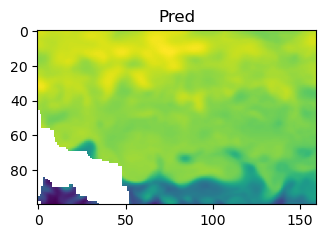

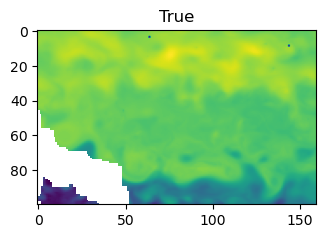

[[19.50654602 19.60103226 19.66182518 ... 18.77263641 18.92498589
  19.0055542 ]
 [19.73067474 19.82735634 19.88082504 ... 18.85393906 19.02752686
  19.15057755]
 [19.98190308 20.08810616 20.13864517 ... 18.90594101 19.08612251
  19.25312042]
 ...
 [ 3.74581146  3.60664749  4.12082291 ... 12.72923946 12.87353134
  12.90942097]
 [ 2.49040222  2.46110439  2.36149216 ... 11.8781395  12.04806709
  12.04953194]
 [        nan         nan  0.83068371 ... 10.66447926 10.70329952
  10.63225174]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer10/CNN_model_layer10_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:14]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer10_st = scaler_l.inverse_transform(result)
y_test_layer10_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer10_unscaled[:,0],predict_layer10_st[:,0])
print('layer10 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer10_unscaled[:,0]-predict_layer10_st[:,0])))
print('layer10 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer10_st
true_data[non_nan_mask] = y_test_layer10_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer10/results.txt", "w") as file:
    file.write(f"layer10 R² score: {r2}\n")
    file.write(f"layer10 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer10/predict_data.npy',predict_data)
np.save(r'./layer10/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer11

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,10:11] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 15)
(12, 16000, 9, 9, 15)
(12, 16000, 9, 9, 15)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 15)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer11/CNN_model_layer11_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:15]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)
 
y_test = y_test.reshape(-1,1)
predict_layer11_st = scaler_l.inverse_transform(result)
y_test_layer11_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer11_unscaled[:,0],predict_layer11_st[:,0])
print('layer11 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer11_unscaled[:,0]-predict_layer11_st[:,0])))
print('layer11 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer11_st
true_data[non_nan_mask] = y_test_layer11_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer11/results.txt", "w") as file:
    file.write(f"layer11 R² score: {r2}\n")
    file.write(f"layer11 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer11/predict_data.npy',predict_data)
np.save(r'./layer11/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

I0000 00:00:1745379707.449593   86872 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745379720.920604   87058 service.cc:152] XLA service 0x7fa55c01dbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745379720.920726   87058 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-23 11:42:00.980838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745379721.202314   87058 cuda_dnn.cc:529] Loaded cuDNN version 90800


   7/5544 ━━━━━━━━━━━━━━━━━━━━ 1:53 20ms/step

I0000 00:00:1745379723.806674   87058 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 693/5544 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step 

KeyboardInterrupt: 

# Layer12

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,11:12] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 16)
(12, 16000, 9, 9, 16)
(12, 16000, 9, 9, 16)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 16)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1745394711.542706   97436 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13603 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745394734.507040  118588 service.cc:152] XLA service 0x7fda20007ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745394734.507155  118588 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-23 15:52:14.603379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745394734.863774  118588 cuda_dnn.cc:529] Loaded cuDNN version 90800


   8/5544 ━━━━━━━━━━━━━━━━━━━━ 1:37 18ms/step

I0000 00:00:1745394736.924344  118588 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step
layer12 R² score: 0.9725443124771118
layer12 Test mae: 0.371
Results written to results.txt
[[15.82973862 15.79748058 15.57398415 ... 13.69715309 13.71340275
  13.60247231]
 [16.19643021 16.0015564  15.83258152 ... 13.84804153 14.00840569
  13.9457655 ]
 [16.45082092 16.28330231 16.1335907  ... 14.1362915  14.2422905
  14.14921856]
 ...
 [ 2.6318419   2.71217084  2.73575997 ... 11.115798   11.22566795
  11.12835884]
 [ 2.19863629  2.09284806  2.0861237  ... 10.32361984 10.45939636
  10.26190472]
 [        nan         nan  1.62858033 ...  9.01423168  9.16435432
   8.89344692]]


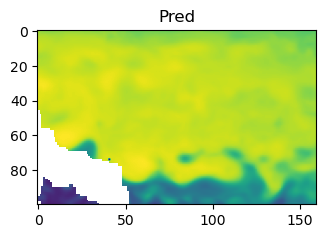

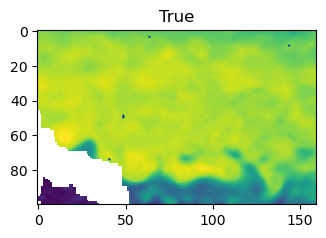

[[15.27375126 15.34406567 15.41950798 ... 13.83376503 13.80227089
  13.54005623]
 [15.56599617 15.66341114 15.73445892 ... 14.11575699 14.23661041
  14.06155586]
 [15.67146873 15.83187294 15.96591091 ... 14.22415829 14.41019917
  14.46293545]
 ...
 [ 0.75817138  0.70470268  1.00134206 ... 10.82634926 11.0160532
  11.08710003]
 [ 0.61534435  0.45054463  0.37730053 ...  9.79360294  9.96865749
   9.99282837]
 [        nan         nan  0.29380348 ...  8.65684986  8.71984005
   8.6700325 ]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer12/CNN_model_layer12_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:16]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer12_st = scaler_l.inverse_transform(result)
y_test_layer12_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer12_unscaled[:,0],predict_layer12_st[:,0])
print('layer12 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer12_unscaled[:,0]-predict_layer12_st[:,0])))
print('layer12 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer12_st
true_data[non_nan_mask] = y_test_layer12_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer12/results.txt", "w") as file:
    file.write(f"layer12 R² score: {r2}\n")
    file.write(f"layer12 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer12/predict_data.npy',predict_data)
np.save(r'./layer12/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer13

In [4]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,12:13] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [5]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 17)
(12, 16000, 9, 9, 17)
(12, 16000, 9, 9, 17)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 17)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1745402252.415715   22178 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745402259.240340   22510 service.cc:152] XLA service 0x7f82d8002a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745402259.240435   22510 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-23 17:57:39.272581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745402259.388836   22510 cuda_dnn.cc:529] Loaded cuDNN version 90800


  12/5544 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step 

I0000 00:00:1745402261.220792   22510 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step
layer13 R² score: 0.9678996801376343
layer13 Test mae: 0.411
Results written to results.txt
[[12.81697655 12.75421524 12.64839077 ... 11.21848011 11.25314999
  11.30992508]
 [13.46428204 13.22697258 13.08485126 ... 11.45852947 11.46867752
  11.55630779]
 [13.88921165 13.76136398 13.62303162 ... 11.75389957 11.70995331
  11.70954418]
 ...
 [ 1.74175406  1.73311853  1.76385546 ...  9.76597595  9.84640503
   9.96915817]
 [ 1.57773829  1.40345144  1.33681536 ...  8.92771244  9.02360439
   9.06556416]
 [        nan         nan  1.10168314 ...  7.81823063  7.790874
   7.69553995]]


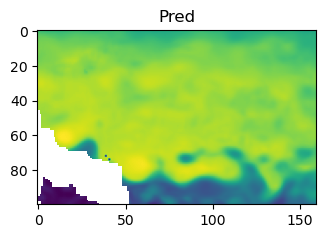

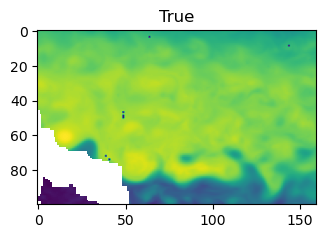

[[12.94824028 13.00610352 13.03466892 ... 11.28046513 11.31049538
  11.18964195]
 [13.33570385 13.4257946  13.49684143 ... 11.57930279 11.60566998
  11.49360657]
 [13.48658752 13.63454056 13.72170162 ... 11.77486515 11.83565807
  11.78731632]
 ...
 [ 0.68053287  0.61095089  0.63438839 ...  9.46986294  9.69252586
   9.77748966]
 [ 0.44541687  0.3414101   0.40000576 ...  8.47740078  8.64293385
   8.6898098 ]
 [        nan         nan  0.29380268 ...  7.53254795  7.5940733
   7.56184578]]


3467

In [6]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer13/CNN_model_layer13_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:17]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer13_st = scaler_l.inverse_transform(result)
y_test_layer13_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer13_unscaled[:,0],predict_layer13_st[:,0])
print('layer13 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer13_unscaled[:,0]-predict_layer13_st[:,0])))
print('layer13 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer13_st
true_data[non_nan_mask] = y_test_layer13_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer13/results.txt", "w") as file:
    file.write(f"layer13 R² score: {r2}\n")
    file.write(f"layer13 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer13/predict_data.npy',predict_data)
np.save(r'./layer13/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer14

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,13:14] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 18)
(12, 16000, 9, 9, 18)
(12, 16000, 9, 9, 18)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 18)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1745561010.671557   23282 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1745561018.914018  162403 service.cc:152] XLA service 0x7fd660007b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745561018.914117  162403 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-25 14:03:38.946862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745561019.071175  162403 cuda_dnn.cc:529] Loaded cuDNN version 90800


  12/5544 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step 

I0000 00:00:1745561021.029171  162403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step
layer14 R² score: 0.9612817168235779
layer14 Test mae: 0.456
Results written to results.txt
[[10.44771099 10.45320797 10.44306374 ...  9.03042889  8.95586014
   8.85653973]
 [10.87427902 10.67811012 10.61005592 ...  9.20270729  9.17935944
   9.12488365]
 [11.18098259 10.99751854 10.92748737 ...  9.44113255  9.36828995
   9.37664032]
 ...
 [ 1.26675534  1.23991704  1.27009225 ...  8.18007183  8.26513767
   8.30390072]
 [ 1.21064591  1.12022805  1.12746835 ...  7.43956947  7.45859671
   7.49502039]
 [        nan         nan  0.99176139 ...  6.57578707  6.65416718
   6.6470027 ]]


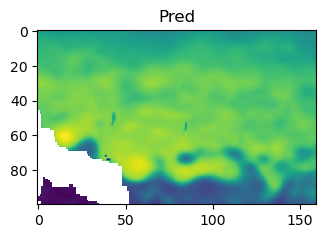

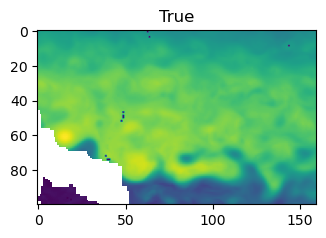

[[10.11441422 10.21036434 10.31656837 ...  9.34095287  9.29993629
   9.15930653]
 [10.46159267 10.57512093 10.69157982 ...  9.52333164  9.49989319
   9.37244797]
 [10.69890404 10.82195473 10.95379543 ...  9.68739891  9.71083736
   9.60756207]
 ...
 [ 0.61095065  0.57432765  0.56846827 ...  8.03207493  8.2562027
   8.34995556]
 [ 0.39414614  0.33701533  0.39561099 ...  7.18317223  7.31427956
   7.34504223]
 [        nan         nan  0.26084155 ...  6.4170351   6.46464443
   6.45292568]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer14/CNN_model_layer14_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:18]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer14_st = scaler_l.inverse_transform(result)
y_test_layer14_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer14_unscaled[:,0],predict_layer14_st[:,0])
print('layer14 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer14_unscaled[:,0]-predict_layer14_st[:,0])))
print('layer14 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer14_st
true_data[non_nan_mask] = y_test_layer14_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer14/results.txt", "w") as file:
    file.write(f"layer14 R² score: {r2}\n")
    file.write(f"layer14 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer14/predict_data.npy',predict_data)
np.save(r'./layer14/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer15

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,14:15] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 19)
(12, 16000, 9, 9, 19)
(12, 16000, 9, 9, 19)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 19)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1746541795.411985    2154 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1746541803.366246   33204 service.cc:152] XLA service 0x7f59fc002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746541803.366358   33204 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-06 22:30:03.400925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746541803.529092   33204 cuda_dnn.cc:529] Loaded cuDNN version 90800


  12/5544 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step 

I0000 00:00:1746541805.973217   33204 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step
layer15 R² score: 0.9454901814460754
layer15 Test mae: 0.456
Results written to results.txt
[[8.54000759 8.58127499 8.41877651 ... 7.71336985 7.64496803 7.47077179]
 [8.71909523 8.54887009 8.66175652 ... 7.78810072 7.77632189 7.64324617]
 [8.91514301 8.75005627 8.80113506 ... 7.88380623 7.84762478 7.66986132]
 ...
 [0.80969131 0.83435142 0.79136455 ... 6.74336624 7.01815319 7.09352636]
 [0.77775562 0.69954479 0.64939201 ... 6.04036951 6.28686476 6.29259872]
 [       nan        nan 0.6133641  ... 5.49061871 5.64498186 5.52328396]]


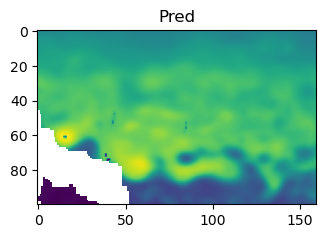

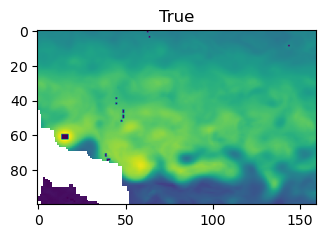

[[8.1397438  8.07162666 8.09872723 ... 8.06723213 8.12436295 8.01742649]
 [8.33091259 8.28843021 8.32944775 ... 8.18076134 8.22910213 8.18662071]
 [8.4964447  8.45616055 8.49205017 ... 8.24594879 8.30014992 8.29428959]
 ...
 [0.55821407 0.54063594 0.52378833 ... 6.54741096 6.71074533 6.79570866]
 [0.36118686 0.30552089 0.37363803 ... 5.94973564 6.03689671 6.05447578]
 [       nan        nan 0.23154439 ... 5.42750359 5.45313931 5.44434929]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer15/CNN_model_layer15_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:19]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer15_st = scaler_l.inverse_transform(result)
y_test_layer15_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer15_unscaled[:,0],predict_layer15_st[:,0])
print('layer15 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer15_unscaled[:,0]-predict_layer15_st[:,0])))
print('layer15 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer15_st
true_data[non_nan_mask] = y_test_layer15_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer15/results.txt", "w") as file:
    file.write(f"layer15 R² score: {r2}\n")
    file.write(f"layer15 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer15/predict_data.npy',predict_data)
np.save(r'./layer15/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer16

In [8]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
layer15_fanyan = np.load(r'./layer15/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan,layer15_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,15:16] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [9]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 20)
(12, 16000, 9, 9, 20)
(12, 16000, 9, 9, 20)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 20)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step
layer16 R² score: 0.9384012818336487
layer16 Test mae: 0.389
Results written to results.txt
[[6.7465291  6.85621977 6.91223145 ... 6.80287933 6.77135611 6.67884302]
 [7.07053518 7.04690266 7.02848816 ... 6.79124165 6.74426794 6.69217443]
 [7.30727339 7.2518301  7.22690201 ... 6.79707623 6.69150829 6.67835474]
 ...
 [0.6227529  0.61063457 0.60763574 ... 5.48449278 5.57605934 5.52875376]
 [0.55569386 0.53370833 0.51861072 ... 5.09241104 5.15556002 5.13549042]
 [       nan        nan 0.49255249 ... 4.74331808 4.70797157 4.56915283]]


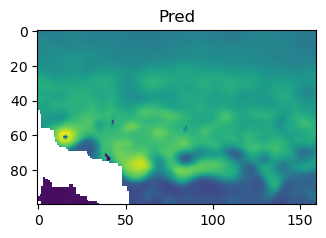

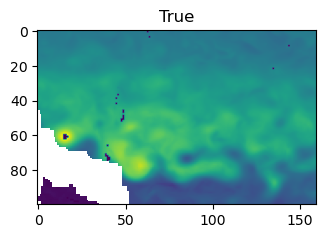

[[7.10187054 6.97076321 6.79351139 ... 6.96783352 7.05352974 7.06012154]
 [7.15167713 7.00372314 6.84331799 ... 7.03228855 7.1040678  7.15607166]
 [7.20294857 7.05572701 6.92168999 ... 7.08429241 7.11285782 7.18024254]
 ...
 [0.58165193 0.5032804  0.48130772 ... 5.39820576 5.50294495 5.56227303]
 [0.33042309 0.28135082 0.34214184 ... 5.04443455 5.10889053 5.12939835]
 [       nan        nan 0.2168939  ... 4.76317596 4.77855682 4.7712326 ]]


14440

In [10]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer16/CNN_model_layer16_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:20]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer16_st = scaler_l.inverse_transform(result)
y_test_layer16_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer16_unscaled[:,0],predict_layer16_st[:,0])
print('layer16 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer16_unscaled[:,0]-predict_layer16_st[:,0])))
print('layer16 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer16_st
true_data[non_nan_mask] = y_test_layer16_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer16/results.txt", "w") as file:
    file.write(f"layer16 R² score: {r2}\n")
    file.write(f"layer16 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer16/predict_data.npy',predict_data)
np.save(r'./layer16/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer17

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
layer15_fanyan = np.load(r'./layer15/predict_data.npy')
layer16_fanyan = np.load(r'./layer16/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan,layer15_fanyan,layer16_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,16:17] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 21)
(12, 16000, 9, 9, 21)
(12, 16000, 9, 9, 21)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 21)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1746607930.944772  366226 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1746607939.151717  407605 service.cc:152] XLA service 0x7f3774009380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746607939.151821  407605 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-07 16:52:19.190899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746607939.324615  407605 cuda_dnn.cc:529] Loaded cuDNN version 90800


  17/5544 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step

I0000 00:00:1746607940.997164  407605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step
layer17 R² score: 0.9212452173233032
layer17 Test mae: 0.293
Results written to results.txt
[[5.9187665  6.07320452 6.05143118 ... 5.77622318 5.7898941  5.74052954]
 [6.22593641 6.20499134 6.21264029 ... 5.73219013 5.74627447 5.69169807]
 [6.27344656 6.26170301 6.24621248 ... 5.69619799 5.68942547 5.7084322 ]
 ...
 [0.54727459 0.55804348 0.57457161 ... 4.73223066 4.85759449 4.95517015]
 [0.52929306 0.52163839 0.53927231 ... 4.56503677 4.6213541  4.70511103]
 [       nan        nan 0.52746439 ... 4.38653708 4.41919327 4.40473843]]


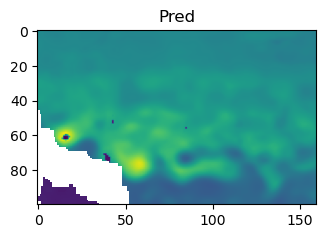

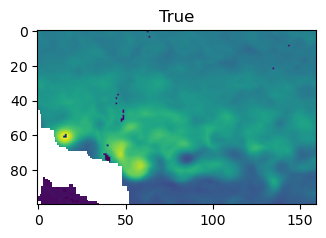

[[6.46244717 6.31229591 6.13211441 ... 6.08816814 6.11014175 6.11893082]
 [6.41264057 6.27640629 6.06472969 ... 6.11673355 6.13064957 6.18485069]
 [6.40385151 6.23465729 6.0149231  ... 6.18338585 6.14456654 6.17679405]
 ...
 [0.46153066 0.41538808 0.40586659 ... 4.62840652 4.69359398 4.7309494 ]
 [0.30918309 0.27915189 0.31138036 ... 4.43284416 4.47093201 4.49290466]
 [       nan        nan 0.21542929 ... 4.26291656 4.27024078 4.27024078]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer17/CNN_model_layer17_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:21]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer17_st = scaler_l.inverse_transform(result)
y_test_layer17_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer17_unscaled[:,0],predict_layer17_st[:,0])
print('layer17 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer17_unscaled[:,0]-predict_layer17_st[:,0])))
print('layer17 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer17_st
true_data[non_nan_mask] = y_test_layer17_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer17/results.txt", "w") as file:
    file.write(f"layer17 R² score: {r2}\n")
    file.write(f"layer17 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer17/predict_data.npy',predict_data)
np.save(r'./layer17/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer18

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
layer15_fanyan = np.load(r'./layer15/predict_data.npy')
layer16_fanyan = np.load(r'./layer16/predict_data.npy')
layer17_fanyan = np.load(r'./layer17/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan,layer15_fanyan,layer16_fanyan,layer17_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,17:18] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 22)
(12, 16000, 9, 9, 22)
(12, 16000, 9, 9, 22)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 22)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1746667289.235436   55355 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28971 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1746667311.934234   55810 service.cc:152] XLA service 0x7f77b8008020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746667311.936097   55810 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-08 09:21:52.107341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746667312.371808   55810 cuda_dnn.cc:529] Loaded cuDNN version 90800


  10/5544 ━━━━━━━━━━━━━━━━━━━━ 1:08 12ms/step

I0000 00:00:1746667313.356795   55810 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step
layer18 R² score: 0.893027663230896
layer18 Test mae: 0.207
Results written to results.txt
[[5.24930906 5.32389212 5.31110239 ... 5.28948975 5.28672123 5.26623201]
 [5.33066511 5.36955166 5.35502195 ... 5.22064447 5.23861885 5.25955725]
 [5.32293224 5.37250519 5.36955023 ... 5.18791533 5.22569132 5.27851725]
 ...
 [0.37345493 0.37700784 0.37165487 ... 4.13560343 4.15060091 4.20212889]
 [0.3645643  0.35562217 0.3426398  ... 3.96823502 3.97761202 4.03288031]
 [       nan        nan 0.32301366 ... 3.80311894 3.78384948 3.82970452]]


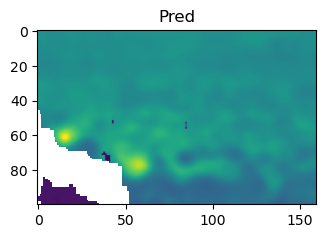

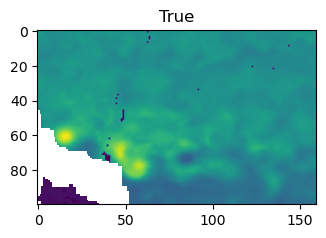

[[5.75637054 5.67287254 5.54908943 ... 5.31543922 5.30957985 5.32715797]
 [5.70949459 5.61867142 5.47657681 ... 5.30738258 5.30665016 5.36524582]
 [5.6714077  5.58131695 5.4062624  ... 5.36158371 5.30518532 5.34693432]
 ...
 [0.39048326 0.35459507 0.35679233 ... 4.05490303 4.0937233  4.11935806]
 [0.29526699 0.27695453 0.28281581 ... 3.91793609 3.94503593 3.9640789 ]
 [       nan        nan 0.21103464 ... 3.77584076 3.78682899 3.78975868]]


3472

In [6]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer18/CNN_model_layer18_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:22]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer18_st = scaler_l.inverse_transform(result)
y_test_layer18_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer18_unscaled[:,0],predict_layer18_st[:,0])
print('layer18 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer18_unscaled[:,0]-predict_layer18_st[:,0])))
print('layer18 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer18_st
true_data[non_nan_mask] = y_test_layer18_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer18/results.txt", "w") as file:
    file.write(f"layer18 R² score: {r2}\n")
    file.write(f"layer18 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer18/predict_data.npy',predict_data)
np.save(r'./layer18/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer19

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
layer15_fanyan = np.load(r'./layer15/predict_data.npy')
layer16_fanyan = np.load(r'./layer16/predict_data.npy')
layer17_fanyan = np.load(r'./layer17/predict_data.npy')
layer18_fanyan = np.load(r'./layer18/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan,layer15_fanyan,layer16_fanyan,layer17_fanyan,
                                  layer18_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,18:19] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 23)
(12, 16000, 9, 9, 23)
(12, 16000, 9, 9, 23)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 23)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1746676184.959331   57321 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1746676193.679834   94248 service.cc:152] XLA service 0x7f2c5c005460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746676193.679916   94248 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-08 11:49:53.714913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746676193.863579   94248 cuda_dnn.cc:529] Loaded cuDNN version 90800


  17/5544 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step

I0000 00:00:1746676195.927672   94248 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step
layer19 R² score: 0.8754723072052002
layer19 Test mae: 0.160
Results written to results.txt
[[4.51734638 4.54088593 4.54039431 ... 4.60131693 4.57736158 4.52385855]
 [4.52749634 4.51705122 4.52955914 ... 4.56488228 4.56535339 4.56439734]
 [4.51370096 4.50510263 4.51566124 ... 4.51750994 4.53521729 4.55475187]
 ...
 [0.32905239 0.34324139 0.36516732 ... 3.60213304 3.63010597 3.6253891 ]
 [0.29777163 0.30360311 0.31363815 ... 3.49182415 3.50736332 3.50311661]
 [       nan        nan 0.27898926 ... 3.34977937 3.36427903 3.36175776]]


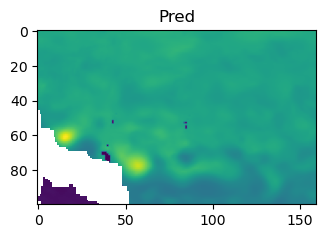

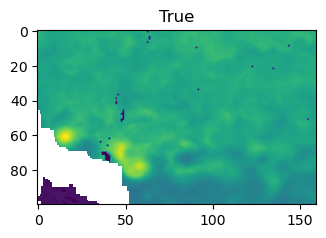

[[4.92358208 4.84521103 4.74706268 ... 4.55516243 4.5807972  4.65184402]
 [4.88915634 4.80858803 4.70165062 ... 4.52879333 4.54490852 4.66063499]
 [4.86718369 4.77709198 4.64964676 ... 4.58152962 4.51853943 4.5910511 ]
 ...
 [0.34873575 0.29453462 0.29380244 ... 3.57075691 3.59492874 3.60664749]
 [0.27475756 0.2571792  0.24472779 ... 3.44990349 3.46894836 3.48213196]
 [       nan        nan 0.21176714 ... 3.33857155 3.34223366 3.3334446 ]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer19/CNN_model_layer19_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:23]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer19_st = scaler_l.inverse_transform(result)
y_test_layer19_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer19_unscaled[:,0],predict_layer19_st[:,0])
print('layer19 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer19_unscaled[:,0]-predict_layer19_st[:,0])))
print('layer19 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer19_st
true_data[non_nan_mask] = y_test_layer19_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer19/results.txt", "w") as file:
    file.write(f"layer19 R² score: {r2}\n")
    file.write(f"layer19 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer19/predict_data.npy',predict_data)
np.save(r'./layer19/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()

# Layer20

In [3]:
data_surface = data_surface_processed[120:132,:,:,:]

data_input = data_surface

data_st = data_st_processed[120:132,:,:,:]
layer1_fanyan = np.load(r'./layer1/predict_data.npy')
layer2_fanyan = np.load(r'./layer2/predict_data.npy')
layer3_fanyan = np.load(r'./layer3/predict_data.npy')
layer4_fanyan = np.load(r'./layer4/predict_data.npy')
layer5_fanyan = np.load(r'./layer5/predict_data.npy')
layer6_fanyan = np.load(r'./layer6/predict_data.npy')
layer7_fanyan = np.load(r'./layer7/predict_data.npy')
layer8_fanyan = np.load(r'./layer8/predict_data.npy')
layer9_fanyan = np.load(r'./layer9/predict_data.npy')
layer10_fanyan = np.load(r'./layer10/predict_data.npy')
layer11_fanyan = np.load(r'./layer11/predict_data.npy')
layer12_fanyan = np.load(r'./layer12/predict_data.npy')
layer13_fanyan = np.load(r'./layer13/predict_data.npy')
layer14_fanyan = np.load(r'./layer14/predict_data.npy')
layer15_fanyan = np.load(r'./layer15/predict_data.npy')
layer16_fanyan = np.load(r'./layer16/predict_data.npy')
layer17_fanyan = np.load(r'./layer17/predict_data.npy')
layer18_fanyan = np.load(r'./layer18/predict_data.npy')
layer19_fanyan = np.load(r'./layer19/predict_data.npy')
data_underwater = np.concatenate((layer1_fanyan,layer2_fanyan,layer3_fanyan,layer4_fanyan,layer5_fanyan,layer6_fanyan,layer7_fanyan,layer8_fanyan,layer9_fanyan,
                                  layer10_fanyan,layer11_fanyan,layer12_fanyan,layer13_fanyan,layer14_fanyan,layer15_fanyan,layer16_fanyan,layer17_fanyan,
                                  layer18_fanyan,layer19_fanyan), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[120:132,:,:,19:20] #(132,  100，160， 1)
print(out_data_y.shape)

(12, 108, 168, 5) (12, 100, 160, 20)
(12, 100, 160, 1)


In [4]:
time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

# 修改变量形状
out_data_reshape = out_data.reshape((12,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
out_data_y_reshape = out_data_y_reshape.reshape(-1,12,1)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)

nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]

out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)


x_test = out_data_reshape
y_test = out_data_y_reshape

# 将前两个维度进行合并  时间*(lat*lon)
x_test = np.reshape(x_test,(-1,9,9,channel))
y_test = np.reshape(y_test,(-1,1))


x_test_shape = x_test.shape
y_test_shape = y_test.shape

scaler_f = StandardScaler()
x_test = scaler_f.fit_transform(x_test.reshape(-1,x_test_shape[3]))

scaler_l = StandardScaler()
y_test = scaler_l.fit_transform(y_test.reshape(-1,y_test_shape[1])) 

x_test = np.reshape(x_test,(-1,9,9,channel))#111792，9，9，5
y_test = np.reshape(y_test,(-1,1))#111792，15
print(scaler_l.mean_.shape,scaler_l.scale_.shape)

(12, 100, 160, 9, 9, 24)
(12, 16000, 9, 9, 24)
(12, 16000, 9, 9, 24)
(16000, 81)
out_data_reshape: (12, 14783, 9, 9, 24)
out_data_y_reshape: (12, 14783, 1)
(1,) (1,)


I0000 00:00:1746684937.499126   33621 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9
I0000 00:00:1746684947.390748   33811 service.cc:152] XLA service 0x7f97d4007e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746684947.390854   33811 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-08 14:15:47.425026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746684947.557981   33811 cuda_dnn.cc:529] Loaded cuDNN version 90800


  17/5544 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step

I0000 00:00:1746684949.157252   33811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step
layer20 R² score: 0.8736810684204102
layer20 Test mae: 0.128
Results written to results.txt
[[3.74470806 3.78235698 3.79708076 ... 3.8418591  3.82805824 3.83524966]
 [3.83170915 3.80672336 3.80469894 ... 3.86003208 3.87194872 3.89478159]
 [3.84665394 3.82803965 3.81991339 ... 3.86708736 3.89613032 3.9127624 ]
 ...
 [0.19811109 0.20453861 0.2231622  ... 3.10650897 3.13724279 3.14490104]
 [0.19171789 0.20019844 0.21885112 ... 3.04393554 3.06617475 3.07736826]
 [       nan        nan 0.20220855 ... 2.98150682 3.0052011  3.01108551]]


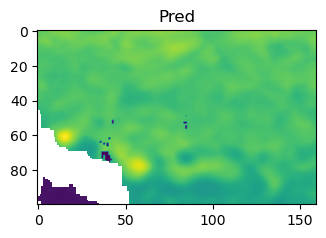

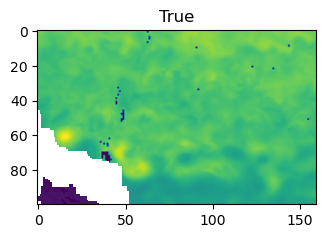

[[4.15378189e+00 4.11276627e+00 4.06442451e+00 ... 3.95309258e+00
  3.94576836e+00 3.94650078e+00]
 [4.11789322e+00 4.05050850e+00 3.99484253e+00 ... 3.94210625e+00
  3.94064140e+00 3.97140503e+00]
 [4.04684639e+00 3.98678589e+00 3.95968437e+00 ... 3.96114922e+00
  3.92086601e+00 3.95382500e+00]
 ...
 [3.54437226e-08 2.16894180e-01 2.22023040e-01 ... 3.15399551e+00
  3.17304039e+00 3.18036461e+00]
 [2.63771087e-01 2.32276946e-01 2.16894180e-01 ... 3.06390572e+00
  3.07708931e+00 3.09393692e+00]
 [           nan            nan 2.19825774e-01 ... 2.97381592e+00
  2.99432373e+00 3.02362061e+00]]


3472

In [5]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer20/CNN_model_layer20_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:24]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer20_st = scaler_l.inverse_transform(result)
y_test_layer20_unscaled = scaler_l.inverse_transform(y_test)

r2 = r2_score(y_test_layer20_unscaled[:,0],predict_layer20_st[:,0])
print('layer20 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer20_unscaled[:,0]-predict_layer20_st[:,0])))
print('layer20 Test mae: %.3f' % mae)

predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer20_st
true_data[non_nan_mask] = y_test_layer20_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer20/results.txt", "w") as file:
    file.write(f"layer20 R² score: {r2}\n")
    file.write(f"layer20 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer20/predict_data.npy',predict_data)
np.save(r'./layer20/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()